# Assignment 3: Convolutional Neural Networks

## DTSC-680: Applied Machine Learning

## Name:

### Overview

The [`CIFAR10` dataset](https://keras.io/api/datasets/cifar10/) contains 50,000 32 $\times$ 32 colored images of the things listed below. 

| Label    | Description |
| -------- | -------|
| 0 | airplane    |
| 1 | automobile     |
| 2 | bird    |
| 3 | cat    |
| 4 | deer    |
| 5 | dog    |
| 6 | frog    |
| 7 | horse    |
| 8 | ship    |
| 9 | truck    |

The `base_model` contains a CNN that was trained on over 17,000 CIFAR10 images, none of which contained a horse, ship, or truck. In this assignment, you will use the bottleneck layers of the `base_model`, along with transfer learning to build a network that can classify all 10 categories of the images in the CIFAR10 dataset.

### Install Tensorflow 2.9.2

In [ ]:
# CODE PROVIDED
import subprocess
import sys
from IPython.display import clear_output
def update_libraries():
    tf_desired_version = "2.9.2"

    try:
        import tensorflow as tf
        tf_installed_version = tf.__version__
    except ImportError:
        tf_installed_version = None

    # Update pip to the latest version
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip'])
    print("Pip updated!")
    
    #Check for the right version
    if tf_installed_version != tf_desired_version:
        print(f"Current TensorFlow version: {tf_installed_version}. Installing version {tf_desired_version}...")
        
        # Uninstall the current TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', 'tensorflow'])
        
        # Install the desired TensorFlow version
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'tensorflow=={tf_desired_version}'])

        clear_output()
        print("TensorFlow version {tf_desired_version} installed successfully")
        
    else:
        print(f"TensorFlow version {tf_desired_version} is already installed.")    


    print(f"Please restart your kernel to apply the changes.")
    
update_libraries()

In [1]:
# common imports
import numpy as np
import pandas as pd

### Data and Model Prep

Load the `base_model` and then run the following cell to load the data.

In [2]:
# STUDENTS CODE
from tensorflow.keras.models import load_model
base_model = load_model('base_model3.h5')


In [3]:
# CODE PROVIDED -- takes almost 3 minutes to run
x_train = np.loadtxt('data/x_train.txt').reshape(32516, 32, 32, 3)
y_train = np.loadtxt('data/y_train.txt')
x_test = np.loadtxt('data/x_test.txt').reshape(6512, 32, 32, 3)
y_test = np.loadtxt('data/y_test.txt')

Let's test the `base_model`. The below code loads and displays a sample image of a ship from the test dataset. Use the `base_model` to make a prediction about the object contained in the sample image.

8.0


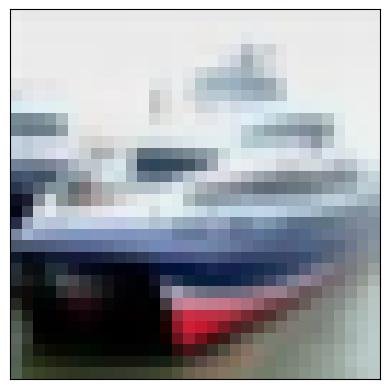

In [4]:
# CODE PROVIDED
%matplotlib inline
import matplotlib.pyplot as plt
x = x_test[0]

print(y_test[0])
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [5]:
# CODE PROVIDED
from tensorflow.keras.preprocessing import image

# preprocess the image
x = image.img_to_array(x_test[0])
x = np.expand_dims(x, axis=0)

# STUDENTS CODE
prediction = base_model.predict(x)
predicted_class = np.argmax(prediction)

print("Predicted class:", predicted_class)
print("Prediction probabilities:", prediction)

1/1 [==============================] - 0s 115ms/step
Predicted class: 1
Prediction probabilities: [[1.0781817e-01 8.9212847e-01 4.9011480e-05 3.9390525e-06 2.2663464e-07
  1.6919363e-07 2.2266207e-09]]


What does the `base_model` predict that the sample image is? Let's use transfer learning to create a domain-specific model that can classify images of horses, ships, and trucks in addition to the rest of the images that the `base_model` was trained on.

The below code extracts the bottleneck layers from the `base_model`.

In [6]:
from tensorflow.keras.models import Model

model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[3].output)

### Transfer Learning

Create the classification layers for transfer learning and train them.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

classification = Sequential()
classification.add(Flatten(input_shape=model.output_shape[1:]))
classification.add(Dense(512, activation='relu'))
classification.add(Dropout(0.5))
classification.add(Dense(10, activation='softmax'))

classification.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [8]:
# Extract bottleneck features for train and test sets
x_train_features = model.predict(x_train)
x_test_features = model.predict(x_test)

204/204 [==============================] - 1s 6ms/step


In [9]:
# Train the classification model
hist = classification.fit(
    x_train_features, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_features, y_test)
)

Epoch 1/10
509/509 [==============================] - 4s 8ms/step - loss: 1.1914 - accuracy: 0.5840 - val_loss: 0.9699 - val_accuracy: 0.6671
Epoch 2/10
509/509 [==============================] - 4s 7ms/step - loss: 0.9561 - accuracy: 0.6671 - val_loss: 0.9212 - val_accuracy: 0.6786
Epoch 3/10
509/509 [==============================] - 4s 7ms/step - loss: 0.8534 - accuracy: 0.7045 - val_loss: 0.8751 - val_accuracy: 0.6924
Epoch 4/10
509/509 [==============================] - 4s 7ms/step - loss: 0.7782 - accuracy: 0.7305 - val_loss: 0.8531 - val_accuracy: 0.7082
Epoch 5/10
509/509 [==============================] - 4s 8ms/step - loss: 0.7159 - accuracy: 0.7533 - val_loss: 0.8228 - val_accuracy: 0.7144
Epoch 6/10
509/509 [==============================] - 4s 7ms/step - loss: 0.6666 - accuracy: 0.7677 - val_loss: 0.8295 - val_accuracy: 0.7178
Epoch 7/10
509/509 [==============================] - 4s 8ms/step - loss: 0.6083 - accuracy: 0.7867 - val_loss: 0.8038 - val_accuracy: 0.7299
Epoch 

Plot the training and validation accuracy.

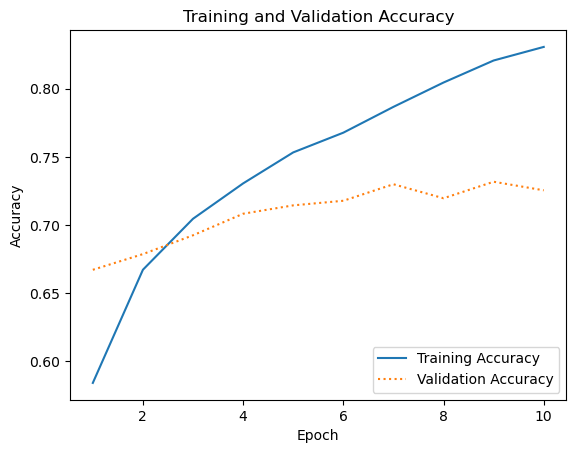

In [10]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Check to ensure the new model correctly classifies the sample image of a ship.

In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np


x_sample = image.img_to_array(x_test[0])
x_sample = np.expand_dims(x_sample, axis=0)


sample_features = model.predict(x_sample)

1/1 [==============================] - 0s 18ms/step


In [13]:
pred_probs = classification.predict(sample_features)
predicted_class = np.argmax(pred_probs)

print("Predicted class:", predicted_class)
print("Prediction probabilities:", pred_probs)
print("True label:", int(y_test[0]))

1/1 [==============================] - 0s 48ms/step
Predicted class: 8
Prediction probabilities: [[1.4552599e-03 1.0814604e-01 3.3573162e-09 1.0368709e-09 1.7054077e-09
  2.9400080e-11 1.2197515e-12 2.3134393e-10 8.8949561e-01 9.0307364e-04]]
True label: 8


### Export Models for codegrade evaluation

Export Classification and CNN models

In [14]:

#export your classification model
classification.save('classification_model.h5')

#export your CNN model
model.save('CNN_model.h5')